In [1]:
# %pip install pretty_midi
# pretty_midi is used to read and write midi files.

# %pip install librosa
# librosa is used to plot and analyze midi data.

# %pip install mir_eval
# mir_eval is used to visualize midi data.

In [2]:
import pretty_midi
import librosa
import numpy as np
import pandas as pd
import uuid
import os
import mir_eval.display
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
from tqdm.notebook import tqdm

In [3]:
def plot_piano_roll(pm:pretty_midi.PrettyMIDI, start_pitch=pretty_midi.note_name_to_number('C2'), end_pitch=pretty_midi.note_name_to_number('G7'), fs=100):
    """
    Plot a piano roll of a pretty_midi object.

    Args:
        pm (pretty_midi.PrettyMIDI): A pretty_midi object.
        start_pitch (int): The MIDI pitch number to start plotting from.
        end_pitch (int): The MIDI pitch number to end plotting at.
        fs (int, optional): The sampling frequency used to generate the piano roll. Defaults to 100.

    Returns:
        None
    """
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

In [4]:
def play_pm(pm:pretty_midi.PrettyMIDI, fs=44100) -> None:
    display(IPython.display.Audio(pm.synthesize(fs=fs), rate=fs))


In [5]:
def print_midi_info(pm:pretty_midi.PrettyMIDI):
    print(f'There are {len(pm.time_signature_changes)} time signature changes')
    print(f'There are {len(pm.instruments)} instruments')
    print(f'Tempo: {pm.estimate_tempo()}')
    for i, instrument in enumerate(pm.instruments):
        print('-'*40)
        print(f'Instrument {i} has {len(instrument.notes)} notes')
        notes_info = []
        for note in instrument.notes:
            note_info = {
                'Tick': pm.time_to_tick(note.start),
                'StartTime': note.start,
                'EndTime': note.end,
                'Pitch': note.pitch,
                'Note': pretty_midi.note_number_to_name(note.pitch),
                'Velocity': note.velocity,
                'Duration': note.end - note.start
            }
            notes_info.append(note_info)
        df = pd.DataFrame(notes_info)
        df.sort_values('Tick', inplace=True)
        print(df)
    print('-'*40)

In [6]:
def plot_piano_roll_with_beats(pm, start_pitch=pretty_midi.note_name_to_number('C2'), end_pitch=pretty_midi.note_name_to_number('G7'), fs=100, xlim=(0, 5)):
    """
    Plot a piano roll of a pretty_midi object, with beat and downbeat markers.

    Args:
        pm (pretty_midi.PrettyMIDI): A pretty_midi object.
        start_pitch (int): The MIDI pitch number to start plotting from.
        end_pitch (int): The MIDI pitch number to end plotting at.
        fs (int, optional): The sampling frequency used to generate the piano roll. Defaults to 100.
        xlim (int, optional): The x-limit of the plot. Defaults to 5.

    Returns:
        None
    """
    # Get beat and downbeat times
    beats = pm.get_beats()
    downbeats = pm.get_downbeats()

    # Plot piano roll
    plt.figure(figsize=(16, 4))
    plot_piano_roll(pm, start_pitch, end_pitch, fs=fs)
    ymin, ymax = plt.ylim()

    # Plot beats as grey lines, downbeats as red lines
    mir_eval.display.events(beats, base=ymin, height=ymax, color='#AAAAAA')
    mir_eval.display.events(downbeats, base=ymin, height=ymax, color='r')

    # Set xlim for clarity
    plt.xlim(xlim)
    plt.show()


In [7]:
def quantize_pretty_midi(pm:pretty_midi.PrettyMIDI, threshold=1/8):
    quantized_pm = pretty_midi.PrettyMIDI()
    beats = pm.get_beats()
    threshold = threshold * (beats[1]- beats[0])
    for instrument in pm.instruments:
        quantized_instrument = pretty_midi.Instrument(program=instrument.program)
        notes = []
        for note in instrument.notes:
            nearest_start_beat = min(beats, key=lambda x: abs(x - note.start))
            if abs(nearest_start_beat - note.start) <= threshold:
                note.start = nearest_start_beat
            if abs(note.end - note.start) < threshold:
                nearest_end_beat = min(beats, key=lambda x: abs(x - note.end))
                if abs(nearest_end_beat - note.end) <= threshold:
                    note.end = nearest_end_beat
            notes.append(note)
        notes.sort(key=lambda note: note.start)
        quantized_instrument.notes = notes
        quantized_pm.instruments.append(instrument)

    return quantized_pm

In [8]:
def pm_to_df(pm: pretty_midi.PrettyMIDI) -> pd.DataFrame:
    # Get the downbeats
    downbeats = pm.get_downbeats()

    # Initialize lists for each column
    sentence_list = []
    time_since_downbeat_list = []
    duration_list = []
    velocity_list = []
    time_since_last_note_start_list = []
    instrument_program_list = []
    track_list = []
    sentence_index_list = []

    # Initialize variable for last note start time
    last_note_start_time = 0

    # Iterate over each downbeat
    for i, downbeat in enumerate(downbeats):
        # Find the nearest downbeat to the previous downbeat
        if downbeat == downbeats[-1]:
            next_beat = downbeat + downbeats[-1] - downbeats[-2]
        else:
            next_beat = downbeats[i+1]
        # Get the notes between the previous downbeat and this downbeat
        section_notes = []
        note_instrument_map = {}
        for n, instrument in enumerate(pm.instruments):
            for note in instrument.notes:
                if next_beat > note.start >= downbeat:
                    section_notes.append(note)
                    note_instrument_map[note] = (instrument.program, n)
        # Sort the notes by start time
        section_notes.sort(key=lambda x: x.start)
        # Construct the sentence, time since downbeat, duration, and velocity lists
        sentence = [note.pitch for note in section_notes]
        time_since_downbeat = [note.start - downbeat for note in section_notes]
        duration = [note.end - note.start for note in section_notes]
        velocity = [note.velocity for note in section_notes]
        instrument_program = [note_instrument_map[note][0] for note in section_notes]
        track = [note_instrument_map[note][1] for note in section_notes]
        time_since_last_note_start = []
        for j, note in enumerate(section_notes):
            if j == 0:
                time_since_last_note_start.append(note.start - last_note_start_time)
            else:
                time_since_last_note_start.append(note.start - section_notes[j-1].start)
        # Append the lists to the overall lists
        if len(sentence) > 0:
            sentence_list.append(sentence)
            time_since_downbeat_list.append(time_since_downbeat)
            duration_list.append(duration)
            velocity_list.append(velocity)
            time_since_last_note_start_list.append(time_since_last_note_start)
            instrument_program_list.append(instrument_program)
            track_list.append(track)
            sentence_index_list.append(i)
        # Update last note start time
        if len(section_notes) > 0:
            last_note_start_time = section_notes[-1].start

    # Construct the DataFrame
    df = pd.DataFrame({
        "Sentence": sentence_list,
        "TimeSinceLastNoteStart": time_since_last_note_start_list,
        "TimeSinceDownbeat": time_since_downbeat_list,
        "Duration": duration_list,
        "Velocity": velocity_list,
        "InstrumentProgram": instrument_program_list,
        "Track": track_list,
        "SentenceIndex": sentence_index_list
    })
    df['Tempo'] = pm.estimate_tempo()
    df['MIDI'] = str(uuid.uuid4())[:8]
    

    return df

In [9]:
def df_to_pretty_midi(df:pd.DataFrame, program=0)->pretty_midi.PrettyMIDI:
    """
    Construct a PrettyMIDI object from a DataFrame with columns "Sentence", "Duration", "Velocity", "TimeSinceLastNoteStart".

    Args:
        df (pandas.DataFrame): The DataFrame to construct the PrettyMIDI object from.

    Returns:
        pretty_midi.PrettyMIDI: A PrettyMIDI object constructed from the DataFrame.
    """
    # Create an empty PrettyMIDI object
    pm = pretty_midi.PrettyMIDI()

    inst = pretty_midi.Instrument(program=program)
    pm.instruments.append(inst)

    time = 0
    # Iterate over each row in the DataFrame
    for i, row in df.iterrows():
        # Get the sentence, time since downbeat, duration, velocity, and time since last note start values
        sentence = row["Sentence"]
        duration = row["Duration"]
        velocity = row["Velocity"]
        time_since_last_note_start = row["TimeSinceLastNoteStart"]

        for j, pitch in enumerate(sentence):
            time += time_since_last_note_start[j]
            # Create a note object
            note = pretty_midi.Note(velocity=velocity[j], pitch=pitch, start=time, end=time+duration[j])
            inst.notes.append(note)

    return pm

In [10]:
def parse_midi_files(root_dir: str, save_to="./Data/MidiDataset.csv") -> pd.DataFrame:
    # Initialize the DataFrame to concatenate to
    df = pd.DataFrame()

    # Iterate over all files in the root directory and its subdirectories
    for dirpath, dirnames, filenames in tqdm(list(os.walk(root_dir))):
        # Iterate over all MIDI files in the current directory
        for filename in filenames:
            if filename.endswith((".mid", ".MID", ".midi", ".MIDI")):
                # Load the MIDI file as a PrettyMIDI object
                pm = pretty_midi.PrettyMIDI(os.path.join(dirpath, filename))

                # Convert the PrettyMIDI object to a DataFrame using the pm_to_df function
                file_df = pm_to_df(pm)

                # Concatenate the file DataFrame to the overall DataFrame
                df = pd.concat([df, file_df])

    # Save the resulting DataFrame to a CSV file
    df.to_csv(save_to, index=False)

    return df

There are 1 time signature changes
There are 1 instruments
Tempo: 120.35820895522389
----------------------------------------
Instrument 0 has 16 notes
     Tick  StartTime   EndTime  Pitch Note  Velocity  Duration
0      24   0.012500  0.512500     60   C4       127  0.500000
1     924   0.481250  0.981250     62   D4       127  0.500000
2    1900   0.989583  1.489583     64   E4       123  0.500000
3    2860   1.489583  1.989583     65   F4       119  0.500000
4    3833   1.996354  2.496354     60   C4       123  0.500000
5    4817   2.508854  3.008854     62   D4       127  0.500000
6    5795   3.018229  3.518229     64   E4       127  0.500000
7    6717   3.498438  3.998438     65   F4       125  0.500000
8    7642   3.980208  4.250000     60   C4       127  0.269792
9    8614   4.486458  4.756250     62   D4       125  0.269792
10   9551   4.974479  5.244271     64   E4       122  0.269792
11  10553   5.496354  5.766146     65   F4       119  0.269792
12  11551   6.016146  6.51614

C:\Users\indie\AppData\Local\Temp\ipykernel_1704\3275145503.py:15: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


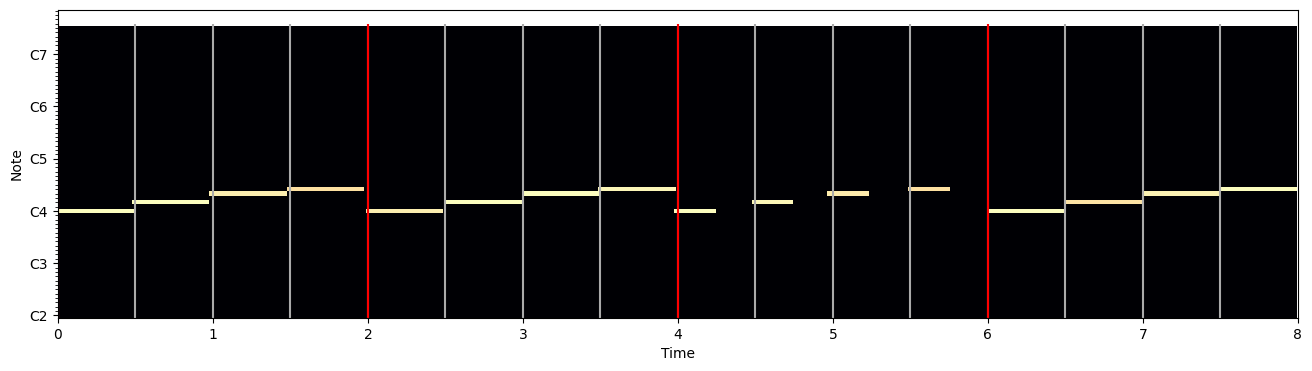

There are 0 time signature changes
There are 1 instruments
Tempo: 120.0
----------------------------------------
Instrument 0 has 16 notes
    Tick  StartTime   EndTime  Pitch Note  Velocity  Duration
0      0        0.0  0.512500     60   C4       127  0.512500
1    220        0.5  0.981250     62   D4       127  0.481250
2    440        1.0  1.489583     64   E4       123  0.489583
3    660        1.5  1.989583     65   F4       119  0.489583
4    880        2.0  2.496354     60   C4       123  0.496354
5   1100        2.5  3.008854     62   D4       127  0.508854
6   1320        3.0  3.518229     64   E4       127  0.518229
7   1540        3.5  3.998438     65   F4       125  0.498438
8   1760        4.0  4.250000     60   C4       127  0.250000
9   1980        4.5  4.756250     62   D4       125  0.256250
10  2200        5.0  5.244271     64   E4       122  0.244271
11  2420        5.5  5.766146     65   F4       119  0.266146
12  2640        6.0  6.516146     60   C4       127  0.

C:\Users\indie\AppData\Local\Temp\ipykernel_1704\3275145503.py:15: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


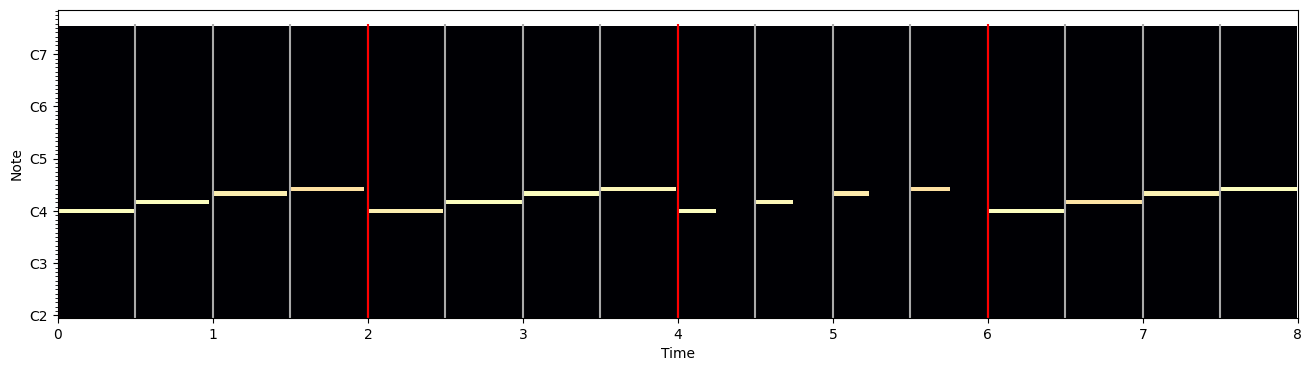

,Sentence,TimeSinceLastNoteStart,TimeSinceDownbeat,Duration,Velocity,InstrumentProgram,Track,SentenceIndex,Tempo,MIDI
0,"[60, 62, 64, 65]","[0.0, 0.5, 0.5, 0.5]","[0.0, 0.5, 1.0, 1.5]","[0.5125, 0.48124999999999996, 0.48958333333333...","[127, 127, 123, 119]","[0, 0, 0, 0]","[0, 0, 0, 0]",0,120.0,7e8869e5
1,"[60, 62, 64, 65]","[0.5, 0.5, 0.5, 0.5]","[0.0, 0.5, 1.0, 1.5]","[0.49635416666666643, 0.5088541666666666, 0.51...","[123, 127, 127, 125]","[0, 0, 0, 0]","[0, 0, 0, 0]",1,120.0,7e8869e5
2,"[60, 62, 64, 65]","[0.5, 0.5, 0.5, 0.5]","[0.0, 0.5, 1.0, 1.5]","[0.25, 0.25624999999999964, 0.2442708333333332...","[127, 125, 122, 119]","[0, 0, 0, 0]","[0, 0, 0, 0]",2,120.0,7e8869e5
3,"[60, 62, 64, 65]","[0.5, 0.5, 0.5, 0.5]","[0.0, 0.5, 1.0, 1.5]","[0.5161458333333329, 0.5067708333333334, 0.506...","[127, 120, 124, 127]","[0, 0, 0, 0]","[0, 0, 0, 0]",3,120.0,7e8869e5


In [11]:
# Lets load a midi file and check the data
pm = pretty_midi.PrettyMIDI('./Data/Test.mid')
print_midi_info(pm)
# We can plot it as well
plot_piano_roll_with_beats(pm, xlim=(0, 8))
# Lets quantize it and plot again
pm_quantized = quantize_pretty_midi(pm)
print_midi_info(pm_quantized)
plot_piano_roll_with_beats(pm_quantized, xlim=(0, 8))
# You can hear it play
play_pm(pm_quantized)
# Lets convert it to dataframe
df = pm_to_df(pm_quantized)
display(df)
# You can also convert df back and convert again to prove it works
pm_df = df_to_pretty_midi(df)
play_pm(pm_df)

In [12]:
# Let's parse all the MIDI files and save them to a csv file
df = parse_midi_files("./Data/MaestroPianoMidi/maestro-v3.0.0/", save_to="./Data/MidiDataset.csv")

  0%|          | 0/11 [00:00<?, ?it/s]